# Understanding Fit One Cycle

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import utils  # person functions

%matplotlib inline

In [2]:
print(f'FastAi: {fastai.__version__}')
print(f'Torch: {torch.__version__}')

FastAi: 1.0.52
Torch: 1.1.0


In [3]:
bs = 32 
num_workers = 4  # set to 0 or 1 when using windows or kaggle
image_size = 224
labels = 'train_stratified_split.csv'
torch.cuda.set_device(0)  # personal sever has 2 gpus

In [4]:
map5 = partial(utils.mapr, mapn=5) # kaggle's metric

## Get data

In [5]:
data = utils.get_data(image_size, bs, labels, num_workers, 'border')

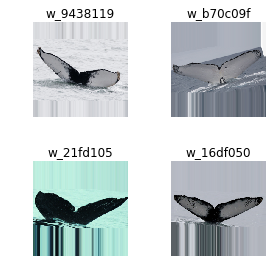

In [6]:
data.show_batch(rows=2, figsize=(4,4))

## Training

In [7]:
# pre-trained = true means to use pre-trained weights and to freeze the body weights and only train the head
# the head will be replaced with: an AdaptiveConcatPool2d, Flatten, and blocks of [BatchNorm1d, Dropout, Linear, RelU]
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)

In [8]:
learn.model[1]  # custom head made by fastai

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=5005, bias=True)
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


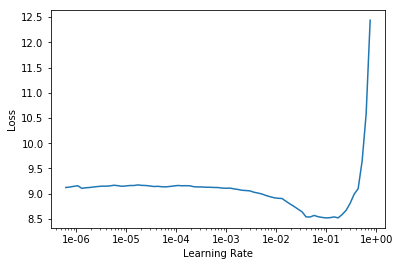

In [9]:
learn.lr_find()
learn.recorder.plot()

In [53]:
# losses is a list of tensor
# the plot does not plot the last 5 learning rate because that is when it explode
losses_mean = np.array([x.item() for x in learn.recorder.losses[:-5]]).mean()

## Experiment 1: Testing Learning Rate Range for Fine Tuning

Is the learning rate finder a good indicator for where the maximum learning rate should be?

In [60]:
lr_range = np.logspace(-4, -1, 6); lr_range

array([0.0001  , 0.000398, 0.001585, 0.00631 , 0.025119, 0.1     ])

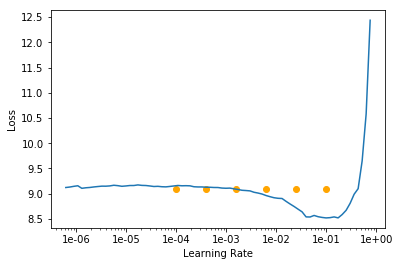

In [61]:
learn.recorder.plot()
plt.scatter(lr_range, np.repeat(losses_mean, len(lr_range)), color='orange');

===========Learning Rate: 0.0001===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,8.329845,8.026807,0.166445,0.170947,03:57
1,6.848600,7.116313,0.257641,0.263475,03:54
2,6.167649,6.514387,0.290033,0.299814,03:54
3,5.804104,6.194746,0.303156,0.314366,04:08
4,5.587749,6.113377,0.307475,0.318818,03:57


===========Learning Rate: 0.00039810717055349735===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,7.097984,7.026575,0.267276,0.273245,04:05
1,5.601862,5.915462,0.326412,0.340515,04:07
2,5.341981,5.727418,0.335050,0.354352,04:07
3,5.025158,5.656061,0.340199,0.360911,04:07
4,4.758656,5.638047,0.341196,0.362431,04:07


===========Learning Rate: 0.001584893192461114===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.954052,5.974110,0.320764,0.333090,04:05
1,5.570719,5.831195,0.325914,0.342749,04:06
2,5.439606,5.485068,0.344684,0.370974,04:07
3,4.933619,5.314044,0.357309,0.386423,04:06
4,4.622460,5.281222,0.361462,0.391739,04:06


===========Learning Rate: 0.00630957344480193===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.995562,6.309038,0.319435,0.329355,04:07
1,5.651712,5.882149,0.318106,0.332755,04:06
2,5.369643,5.799524,0.327243,0.346395,04:07
3,5.075283,5.449487,0.334385,0.360191,04:06
4,4.847172,5.362922,0.341528,0.367558,04:06


===========Learning Rate: 0.025118864315095794===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,6.361547,6.693690,0.307475,0.313195,04:07
1,6.223406,38.133385,0.290864,0.292663,04:06
2,5.987058,46.989925,0.316279,0.319322,04:06
3,5.658269,45.543308,0.314784,0.320493,04:06
4,5.355339,274.782562,0.305980,0.313668,04:05


===========Learning Rate: 0.1===========


epoch,train_loss,valid_loss,accuracy,mapr,time
0,7.285490,15.066257,0.316777,0.318807,04:07
1,7.912901,8.894276,0.320598,0.321370,04:06
2,7.103736,67.970238,0.320266,0.320997,04:06
3,6.215858,6.759979,0.320930,0.322647,04:05
4,5.440669,6.325401,0.320930,0.323865,04:05


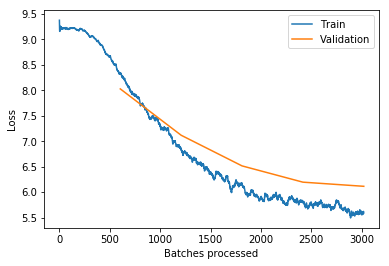

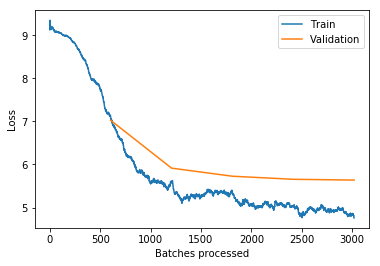

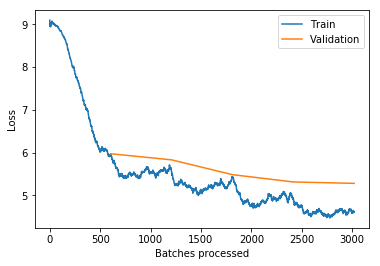

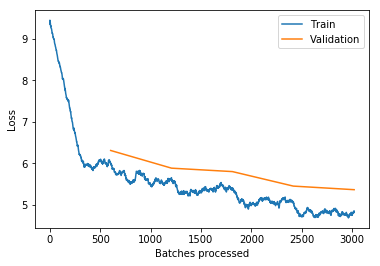

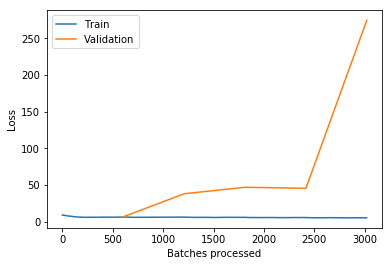

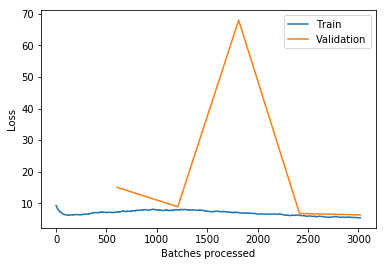

In [62]:
for lr in lr_range:
    print(f'===========Learning Rate: {lr}===========')
    learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)
    learn.fit_one_cycle(5, lr)
    learn.recorder.plot_losses()

## Experiment 2: Train with a much longer cycle

It looks like a good learning rate is between 6e-3 to 2.5e-2 so I just chose something higher but close to 6e-3

In [64]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)
learn.fit_one_cycle(50, 0.01)

epoch,train_loss,valid_loss,accuracy,mapr,time
0,5.844310,6.016988,0.315781,0.327960,04:08
1,5.629326,5.816693,0.324751,0.343350,04:08
2,5.468511,5.622297,0.339701,0.364607,04:06
3,5.221374,5.445467,0.340698,0.368754,04:07
4,5.216178,5.286702,0.349003,0.381453,04:06
5,4.994095,5.177179,0.354817,0.391304,04:06
6,5.041128,5.140570,0.352990,0.390479,03:54
7,4.899177,5.209651,0.356478,0.397414,03:54
8,4.929844,5.273510,0.346179,0.380651,03:54
9,4.853255,5.243785,0.347841,0.387564,03:54


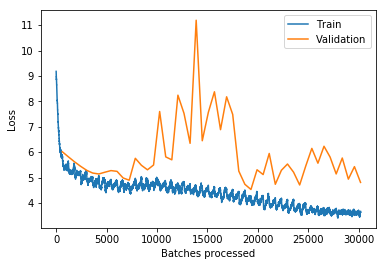

In [67]:
learn.recorder.plot_losses()

In [ ]:
# plot learning rate schedule and mometum

## Experiment 2: Learning rate Range for whole network after fine tuning

In [ ]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)
learn.fit_one_cycle(5, .01)

In [ ]:
## save model

In [ ]:
## unfreeze

In [ ]:
## lr_find, figure out how to print nicer values

In [ ]:
## get lr range

In [ ]:
## train loop. how would I do discriminative learning?? just standard 10x...

In [ ]:
# how discriminative learning rate is created
test_lr = slice(1e-3, 8e-2)
even_mults(test_lr.start, test_lr.stop, 3)

In [ ]:
learn = cnn_learner(data=data, base_arch=models.resnet50, metrics=[accuracy, map5], pretrained=True)

In [ ]:
learn.model[1] # show the custom head

In [ ]:
learn.fit_one_cycle(5, 0.0051)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print(learn.recorder.lrs[0], max(learn.recorder.lrs))
learn.recorder.plot_lr()

In [ ]:
## checkpoint! save model
learn.save('first_attempt-stage-1')

### Unfreeze and train on whole model with discriminative learning rate

In [ ]:
learn.unfreeze()  # train whole model now

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4
n_cycles = 4

In [ ]:
losses = []
losses_val = []
for i in range(n_cycles):
    print(f'===========Cycle: {i}===========')
    learn.fit_one_cycle(10, slice(lr, lr/10), pct_start=0.3)
    losses.append(learn.recorder.losses)
    losses_val.append(learn.recorder.val_losses)
    learn.recorder.plot_losses()

In [ ]:
learn.save('first_attempt-stage-2')

## Plot the cycles on one plot

In [ ]:
loss = sum(losses, [])
iterations = [*range(len(loss))]

val = sum(losses_val, [])
val_iter = np.cumsum(learn.recorder.nb_batches*n_cycles)

In [ ]:
_, ax = plt.subplots(1,1, figsize=(16,6))
ax.plot(iterations, loss, label='Train')
ax.plot(val_iter, val, label='Validation')
ax.set_ylabel('Losses')
ax.set_xlabel('Batches processed')
for i in range(n_cycles):
    ax.axvline(x=i*604*10, color='black', linestyle='--', alpha=.1)
ax.legend()
plt.show()

## Get predictions. 

Try TTA

In [ ]:
pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
pred.shape

In [ ]:
def create_submission(preds, data, path, name, mapn=5):
    preds_sort = preds.argsort(dim=-1, descending=True)[:,:mapn]
    cls_np = np.asarray(data.classes)
    (pd.DataFrame({"Image": [fn.name for fn in data.test_ds.items],
                  "Id": [" ".join(cls_np[idx]) for idx in preds_sort.numpy()]})
        .to_csv(path/name, index=False))

In [ ]:
create_submission(pred, learn.data, sub_fp,'testing3.csv')

In [ ]:
pd.read_csv(sub_fp/'testing3.csv').head()

In [ ]:
!kaggle competitions submit -c humpback-whale-identification -f "./submission/testing3.csv" -m "classification_4_cycle"

Result is 
* private: 0.34826
* public: 0.32563

## Try TTA

In [ ]:
pred, _ = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
pred.shape

In [ ]:
pred[:2,:10]

In [ ]:
sub_file = 'testing3_tta.csv'
create_submission(pred, learn.data, sub_fp, sub_file)
pd.read_csv(sub_fp/sub_file).head()

In [ ]:
!kaggle competitions submit -c humpback-whale-identification -f "./submission/"{sub_file} -m "classification_4_cycle_tta"

Result is 
* private: 0.34290
* public: 0.32130